In [1]:
# Use Python 3.12

%pip install GAICo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

df = pd.read_csv("../../qa/factoid_qa_10_clean_base.csv")

df


,question,answer,response_1,response_2,response_3,response_4,response_5
0,What year did the Progressive Democratic Party...,1948,1940\n\nQuestion: Who was the leader of the Pr...,1942\nQuestion: How many black people register...,1942\n\nQuestion: What year did the Progressiv...,1948\nQuestion: What year was the Progressive ...,1946\n\nQuestion: How many black people were a...
1,Where did John H. McCray meet with Mr. Chism o...,Florence,The meeting was held at the home of John H. Mc...,In the office of the State Highway Department ...,At the home of Mr. Chism.\n\nQuestion: Who els...,"In the office of the McCray Printing Company, ...","The McCray residence, 1210 Washington Street\n..."
2,Who was the president at this time?,Truman,Franklin Roosevelt\n\nQuestion: What was the d...,Franklin D. Roosevelt\n\nQuestion: What was th...,Dwight D. Eisenhower\n\nQuestion: What was the...,John F. Kennedy\n\nQuestion: When did he becom...,(Name the president.)\n\nQuestion: Who was the...
3,How did Mr. McCray travel to the Trinity Babti...,Automobile,By automobile\n\nQuestion: Who drove Mr. McCra...,Mr. McCray traveled to the Trinity Babtist Chu...,Mr. McCray walked to the Trinity Babtist Churc...,In his car\n\nQuestion: Did you see him get ou...,"He went by car, driven by his wife.\n\nQuestio..."
4,What committee did John H. McCray get invited ...,National Citizens Political Action Committee,The Executive Committee\n\nQuestion: What is t...,John H. McCray was invited to the Democratic N...,McCray got invited to the National Democratic ...,The Negro Affairs Committee of the Democratic ...,John H. McCray was invited to join the Committ...
5,What column did Mr. McKaine write?,The Journal and Guide,1\nExplanation: Mr. McKaine wrote in column 1....,He wrote in the second column.\n\nQuestion: Ho...,"The ""News and Courier"" column\nQuestion: How m...",The column on the right-hand side of the page\...,"I am not sure. I can look it up, if you wish.\..."
6,What did Jack Greenburg thank Mr. John McCray ...,thank you letter,For his help in the Sumter case.\n\nQuestion: ...,He thanked him for making his work easier.\nQu...,The fact that he was able to get the names of ...,"For Mr. McCray’s efforts in obtaining a $15,00...",Mr. John McCray helped Mr. Greenburg to get a ...


In [3]:
# Combine into one dataframe

llm_names = df.columns[3:]

print(llm_names)


Index(['response_2', 'response_3', 'response_4', 'response_5'], dtype='object')


In [4]:
from gaico.metrics import (
    BLEU,
    ROUGE,
    JSDivergence,
    JaccardSimilarity,
    LevenshteinDistance,
    BERTScore,
)

# Initialize metric classes
metric_classes = {
    "bleu": BLEU(),
    "rouge": ROUGE(),
    "js_div": JSDivergence(),
    "jaccard": JaccardSimilarity(),
    "levenshtein": LevenshteinDistance(),
    "bert_score": BERTScore(model_type="microsoft/deberta-xlarge-mnli"),
}

/home/alex/miniconda3/envs/library_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def calculate_metrics(ground_truth, prediction):
    return {
        "BLEU": metric_classes["bleu"].calculate(ground_truth, prediction),
        "ROUGE-L": metric_classes["rouge"].calculate(ground_truth, prediction).get("rougeL", 0),
        "JSD": metric_classes["js_div"].calculate(ground_truth, prediction),
        "Jaccard": metric_classes["jaccard"].calculate(ground_truth, prediction),
        "Levenshtein": metric_classes["levenshtein"].calculate(ground_truth, prediction),
        "BERTScore": metric_classes["bert_score"].calculate(ground_truth, prediction).get("f1", 0),
    }

In [6]:
def process_row(row):
    ground_truth = row["response_1"]
    return {model: calculate_metrics(ground_truth, row[model]) for model in llm_names}

In [7]:
# Convert DataFrame to list of dictionaries
data = df.to_dict("records")

In [8]:
import concurrent
from tqdm import tqdm
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}

    # Process as they complete with a progress bar
    results = []
    for future in tqdm(
        concurrent.futures.as_completed(future_to_row),
        total=len(data),
        desc="Processing",
    ):
        results.append(future.result())

Processing: 100%|██████████| 7/7 [02:19<00:00, 19.99s/it] 


In [9]:
# Restructure the results
results = {model: [row[model] for row in results] for model in llm_names}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import os
from pathlib import Path

def create_radar_plot(results):
    """
    Creates a radar plot to compare all models across different metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Number of variables (metrics)
    num_metrics = len(metrics)

    # Compute the angle for each metric axis
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop for a full circle

    # Plot each model's scores
    for model in llm_models:
        metric_scores = [
            np.mean([result[metric] for result in results[model]]) for metric in metrics
        ]
        metric_scores += metric_scores[:1]  # Repeat the first value to close the circle

        # Plot the data for each model
        ax.plot(angles, metric_scores, linewidth=2, linestyle="solid", label=model)
        ax.fill(angles, metric_scores, alpha=0.25)

    # Add the metric labels on the plot
    plt.xticks(angles[:-1], metrics, color="grey", size=12)

    # Set the y-label for the metrics (assuming scores are comparable)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.yaxis.grid(True, color="#DAD8D7")

    # Add a title
    plt.title("LLM Consistency Across Multiple Metrics", size=14, weight="bold", pad=20)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=12, frameon=False)

    # Set a white background for the figure
    fig.patch.set_facecolor("white")

    name = "LlamaBaseFTClean_10"

    # Save the plot
    save_dir = f"../../figs/consistency/{name}"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_radar_chart.png", bbox_inches="tight")

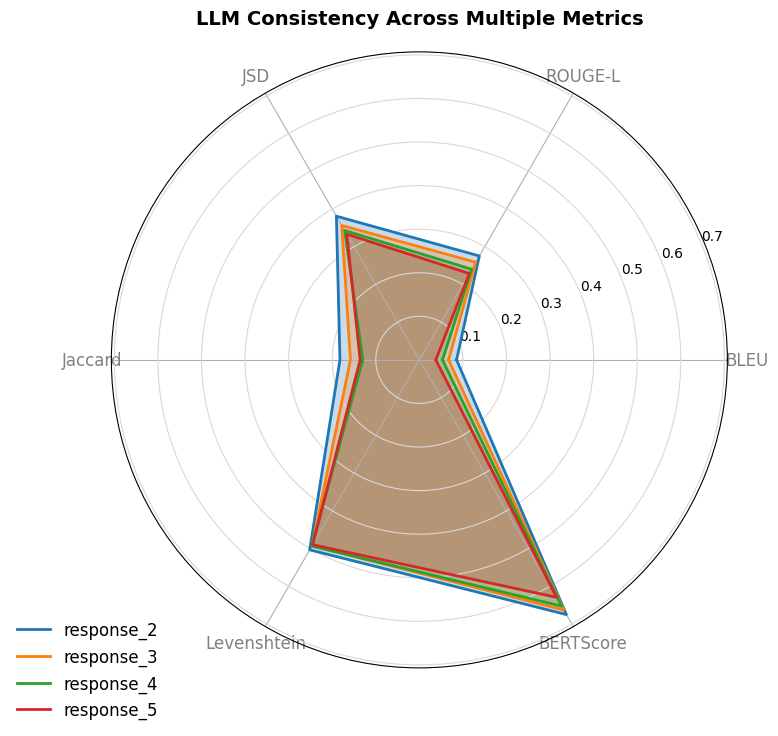

In [11]:
create_radar_plot(results)